<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
:پروژه ی سوم
</font>
</h1>
<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
تحلیل بر هم کنش 
    یک جمعیت نورونی مهاری و دو جمعیت نورونی تحریکی با اتصالات مختلف
</font>
</h1>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color="orange">
  عرشیا ربیعی 
    
</font> 
</p>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color="orange">
۶۱۰۳۹۸۱۲۵ 
    
</font> 
</p>

In [1]:
from pymonntorch import *
import torch
import matplotlib.pyplot as plt


In [2]:
settings = {'device' : 'cpu' , 'def_type' : torch.float32 }
settings = {'device' : 'cpu' , 'def_type' : torch.float32}

torch.manual_seed(73)
N = 100
REGULAR_SPIKE = {'a' : 0.02 , 'b' : 0.2 , 'c' : -65 , 'd' : 8}
IB = {'a' : 0.02 , 'b' : 0.2 , 'c' : -55 , 'd' : 4}
CHATTERING = {'a' : 0.02 , 'b' : 0.2 , 'c' : -50 , 'd' : 2}
LOW_THRESHOLD_SPIKING = {'a' : 0.02 , 'b' : 0.25 , 'c' : -65 , 'd' : 2}
FAST_SPIKING = {'a' : 0.1 , 'b' : 0.2 , 'c' : -65 , 'd' : 2}
PARAMETER_CHOOSE_EXC = REGULAR_SPIKE
PARAMETER_CHOOSE_INH = FAST_SPIKING

TIME = 500


In [3]:
class Time(Behavior):
    def initialize(self,network):
        network.dt = self.parameter('dt' , 1)
        network.passed = 0
    def forward(self , network):
        network.passed += network.dt

In [4]:
class Dendrite(Behavior):
    def forward(self, n):
        for syn in n.afferent_synapses['GABA']:
            n.I -= syn.I
        for syn in n.afferent_synapses['GLUTAMATE']:
            n.I += syn.I

In [5]:
class InputSynapse(Behavior):
    def initialize(self,syn):
        self.density = self.parameter('den' , 1)
        self.W = syn.matrix('uniform' ,density = self.density)
        self.coef = self.parameter('coef' , None)
    def forward(self , syn):
        pre_spike = syn.src.spike
        syn.I = torch.sum(self.W.t()[pre_spike],axis = 0)* self.coef

In [6]:
class Izhikevich_Input(Behavior):
    def initialize(self , n):
        self.type = self.parameter('type' , 'Exc')
        self.to_be_choosen = self.parameter('to_be_choosen' , False) # determine the population which gets more current
        n.I = n.vector('uniform')
        n.I[n.I < 0] = 0
        n.I_stable = torch.clone(n.I)
        self.partition(n , 20)

    def partition(self , n ,parts):
        k = N // parts
        self.masks = []
        for i in range(parts):
            tmp = torch.zeros(n.size , dtype=torch.bool)
            tmp[i*k : (i+1)*k] = True
            self.masks.append(tmp)
    def forward(self , n):
        if n.network.passed < 20:
            i = n.network.passed % 20
            tmp = torch.normal(20 , 3 , size=(n.size//20 ,))
            n.I[self.masks[i]] += tmp
            n.I_stable[self.masks[i]] += tmp
        if n.network.passed >= 130 and n.network.passed <150 and self.to_be_choosen:
            i = n.network.passed % 20
            tmp = torch.normal(20 , 3 , size=(n.size//20 ,))
            n.I[self.masks[i]] += tmp
            n.I_stable[self.masks[i]] += tmp
        n.I[n.I < 0] = 0

In [7]:
class Izhikevich(Behavior):
    def initialize(self , n):
        self.a = self.parameter('a' , None , required=True)
        self.b = self.parameter('b' , None , required=True)
        self.c = self.parameter('c' , None , required=True)
        self.d = self.parameter('d' , None , required=True)
        self.I = self.parameter('I' , 15)
        self.threshold = self.parameter('threshold' , 30)
        n.v = n.vector('uniform') * -70
        n.u = n.vector('uniform') * -15
        n.spike = n.v > self.threshold
        self.dt = 1
    def _fire(self , n):
        n.spike = n.v > self.threshold
        n.v[n.spike] = self.c
        n.u[n.spike] += self.d
    def _dv_du(self,n):
        self.dv = 0.04* (n.v**2) + 5*n.v + 140 - n.u + n.I
        self.du = self.a*(self.b * n.v - n.u)
    def forward(self , n):
        self._fire(n)
        self._dv_du(n)
        n.v += self.dv * n.network.dt
        n.u += self.du * n.network.dt
        n.I_stable = torch.normal(mean=n.I_stable , std=torch.ones(n.size)*0.2)
        n.I = torch.clone(n.I_stable)

In [8]:
net = Network(settings=settings , behavior={
    11 : Time(dt = 1),
})

In [9]:
exc_pop1 = NeuronGroup(net= net , size= N , tag= 'Excitatory' , behavior={
    2 : Izhikevich_Input(),
    4 : Dendrite(),
    5 : Recorder(tag='exc_rec2' , variables = ['I']),
    7 : Izhikevich(**PARAMETER_CHOOSE_EXC , I = 15),
    8 : Recorder(tag='exc_rec' , variables = ['v' , 'u']),
    9 : EventRecorder(tag='exc_spike' , variables=['spike'])
})

In [10]:
exc_pop2 = NeuronGroup(net= net , size= N , tag= 'Excitatory' , behavior={
    2 : Izhikevich_Input(to_be_choosen=True),
    4 : Dendrite(),
    5 : Recorder(tag='exc_rec2' , variables = ['I']),
    7 : Izhikevich(**PARAMETER_CHOOSE_EXC , I = 5),
    8 : Recorder(tag='exc_rec' , variables = ['v' , 'u']),
    9 : EventRecorder(tag='exc_spike' , variables=['spike'])
})

In [11]:
inh_pop = NeuronGroup(net= net , size= N , tag= 'Inhibitory' , behavior={
    2 : Izhikevich_Input(type = 'Inh'),
    4 : Dendrite(),
    5 : Recorder(tag='inh_rec2' , variables = ['I']),
    7 : Izhikevich(**PARAMETER_CHOOSE_INH , I = 5),
    8 : Recorder(tag='inh_rec' , variables = ['v' , 'u']),
    9 : EventRecorder(tag='inh_spike' , variables=['spike'])
})

In [12]:
synapse1 = SynapseGroup(net=net , tag = 'GLUTAMATE', src= exc_pop1 , dst=exc_pop1 , behavior={
    3: InputSynapse(coef =0.7 , den = 1)
})
synapse2 = SynapseGroup(net=net ,tag= 'GLUTAMATE' , src= exc_pop1 , dst=inh_pop , behavior={
    3:InputSynapse(coef = 1, den = 1)
})
# synapse3 = SynapseGroup(net=net ,tag= 'GABA' , src= inh_pop , dst=inh_pop , behavior={
#     3:InputSynapse(coef = 0.01 , den = 1)
# })
synapse4 = SynapseGroup(net=net ,tag= 'GABA' , src= inh_pop , dst=exc_pop2 , behavior={
    3:InputSynapse(coef = 1 , den = 1)
})
# synapse5 = SynapseGroup(net=net ,tag= 'GLUTAMATE' , src= exc_pop2 , dst= exc_pop2, behavior={
#     3:InputSynapse(coef = 0.01 , den = 1)
# })

# synapse6 = SynapseGroup(net=net ,tag= 'GLUTAMATE' , src= exc_pop2 , dst=inh_pop , behavior={
#     3:InputSynapse(coef = 1, den = 1)
# })
# synapse7 = SynapseGroup(net=net ,tag= 'GABA' , src= inh_pop , dst=exc_pop1 , behavior={
#     3:InputSynapse(coef = 0.7 , den = 1)
# })
# synapse8 = SynapseGroup(net=net ,tag= 'GLUTAMATE' , src= exc_pop1 , dst=exc_pop2 , behavior={
#     3:InputSynapse(coef = 0.01 , den = 1)
# })
# synapse9 = SynapseGroup(net=net ,tag= 'GLUTAMATE' , src= exc_pop2 , dst= exc_pop1 , behavior={
#     3:InputSynapse(coef = 0.01 , den = 1)
# })

In [13]:
net.initialize()
net.simulate_iterations(TIME)

Network['Network'](Neurons: tensor(300)|3 groups, Synapses: tensor(30000)|3 groups){11:Time(dt=1,)}
NeuronGroup['Excitatory', 'NeuronGroup', 'ng'](100){2:Izhikevich_Input()4:Dendrite()5:Recorder(tag=exc_rec2,variables=['I'],)7:Izhikevich(a=0.02,b=0.2,c=-65,d=8,I=15,)8:Recorder(tag=exc_rec,variables=['v', 'u'],)9:EventRecorder(tag=exc_spike,variables=['spike'],)}
NeuronGroup['Excitatory', 'NeuronGroup', 'ng'](100){2:Izhikevich_Input(to_be_choosen=True,)4:Dendrite()5:Recorder(tag=exc_rec2,variables=['I'],)7:Izhikevich(a=0.02,b=0.2,c=-65,d=8,I=5,)8:Recorder(tag=exc_rec,variables=['v', 'u'],)9:EventRecorder(tag=exc_spike,variables=['spike'],)}
NeuronGroup['Inhibitory', 'NeuronGroup', 'ng'](100){2:Izhikevich_Input(type=Inh,)4:Dendrite()5:Recorder(tag=inh_rec2,variables=['I'],)7:Izhikevich(a=0.1,b=0.2,c=-65,d=2,I=5,)8:Recorder(tag=inh_rec,variables=['v', 'u'],)9:EventRecorder(tag=inh_spike,variables=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'Excitatory => Excitatory'](D10

803.3249378204346

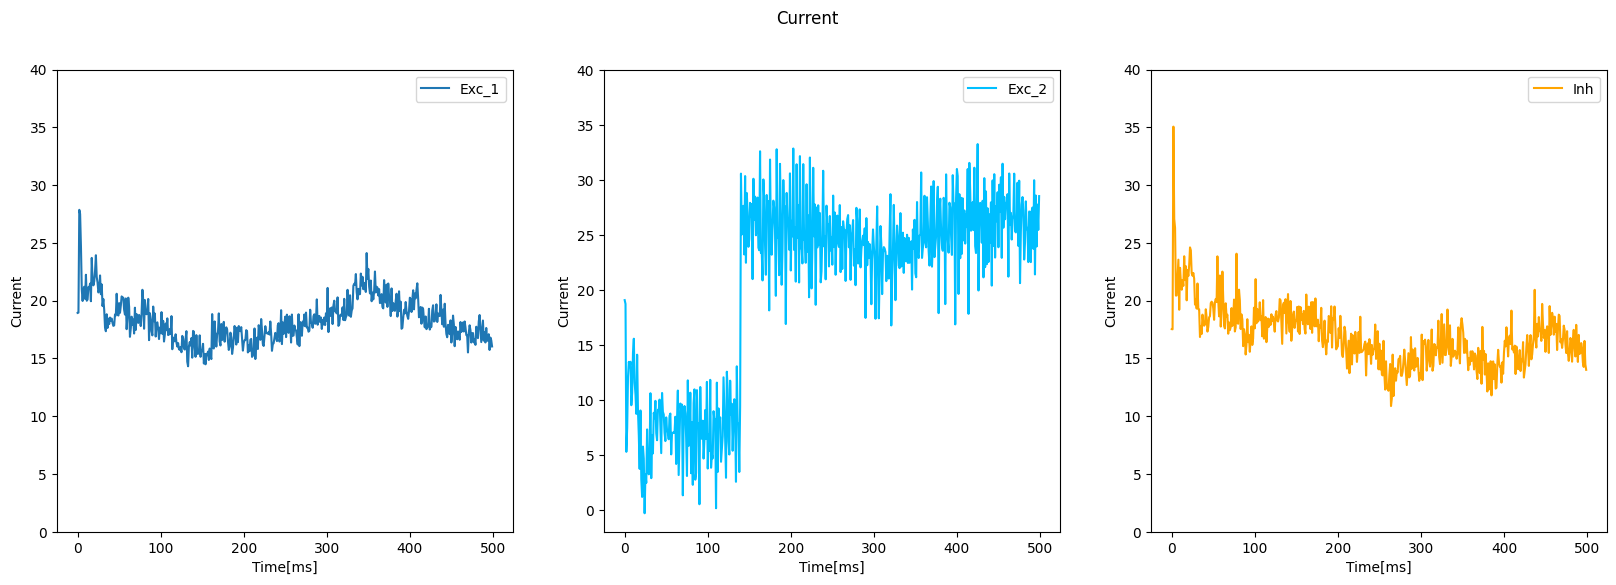

In [14]:
fig , ax = plt.subplots(1,3 , figsize = (20,6))
ax[0].plot(net['exc_rec2' , 0].variables['I'][: , : 1] , label = 'Exc_1')
ax[0].set_xlabel('Time[ms]')
ax[0].yaxis.set_ticks(np.arange(0 , 41 , 5))
ax[0].set_ylabel('Current')
ax[0].legend()


ax[1].plot(net['exc_rec2' , 1].variables['I'][: , : 1] , color ='deepskyblue',label = 'Exc_2')
ax[1].set_xlabel('Time[ms]')
ax[1].yaxis.set_ticks(np.arange(0 , 41 , 5))
ax[1].set_ylabel('Current')
ax[1].legend()


ax[2].plot(net['inh_rec2' , 0].variables['I'][: , : 1] ,color='orange', label = 'Inh')
ax[2].set_xlabel('Time[ms]')
ax[2].set_ylabel('Current')
ax[2].yaxis.set_ticks(np.arange(0 , 41 , 5))
ax[2].legend()
fig.suptitle('Current');

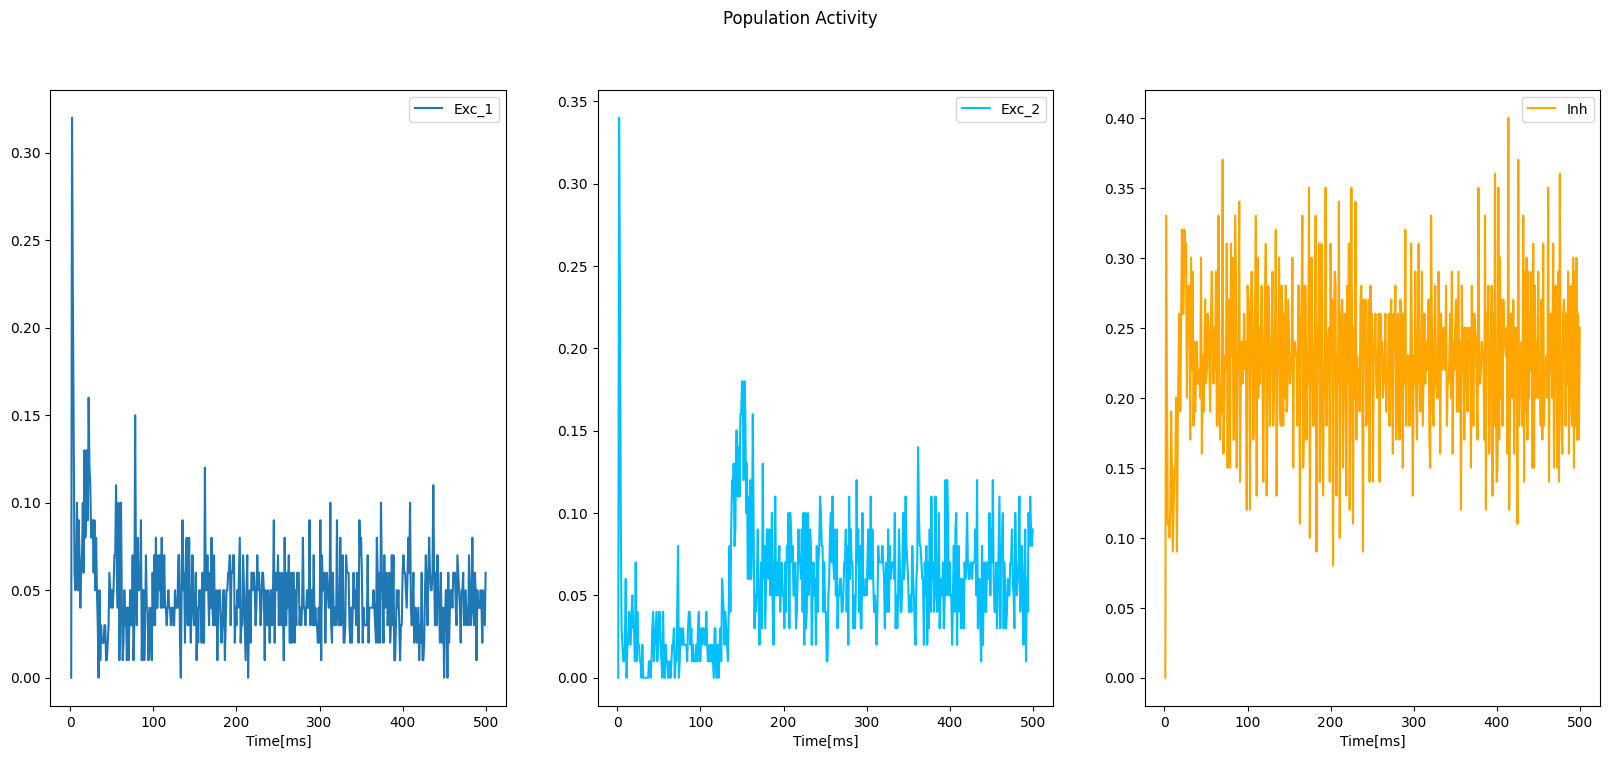

In [15]:
exc_activity = []
exc_activity2 = []
inh_activity = []
for i in range(1 , TIME+1):
    exc_activity.append(torch.sum((net['exc_spike' ,0]['spike' , 0][: , 0] == i)) / N)
    exc_activity2.append(torch.sum((net['exc_spike' ,1]['spike' , 0][: , 0] == i)) / N)
    inh_activity.append(torch.sum((net['inh_spike' ,0]['spike' , 0][: , 0] == i)) / N)

    
fig , ax = plt.subplots(1,3 , figsize= (20, 8))
ax[0].plot([i for i in range(1,TIME+1)] , exc_activity ,label='Exc_1')
ax[0].set_xlabel('Time[ms]')
ax[0].legend()


ax[1].plot([i for i in range(1,TIME+1)] , exc_activity2 , color = 'deepskyblue', label='Exc_2')
ax[1].set_xlabel('Time[ms]')
ax[1].legend()


ax[2].plot([i for i in range(1,TIME+1)] , inh_activity , color= 'orange', label='Inh')
ax[2].set_xlabel('Time[ms]')
ax[2].legend()


fig.suptitle('Population Activity');

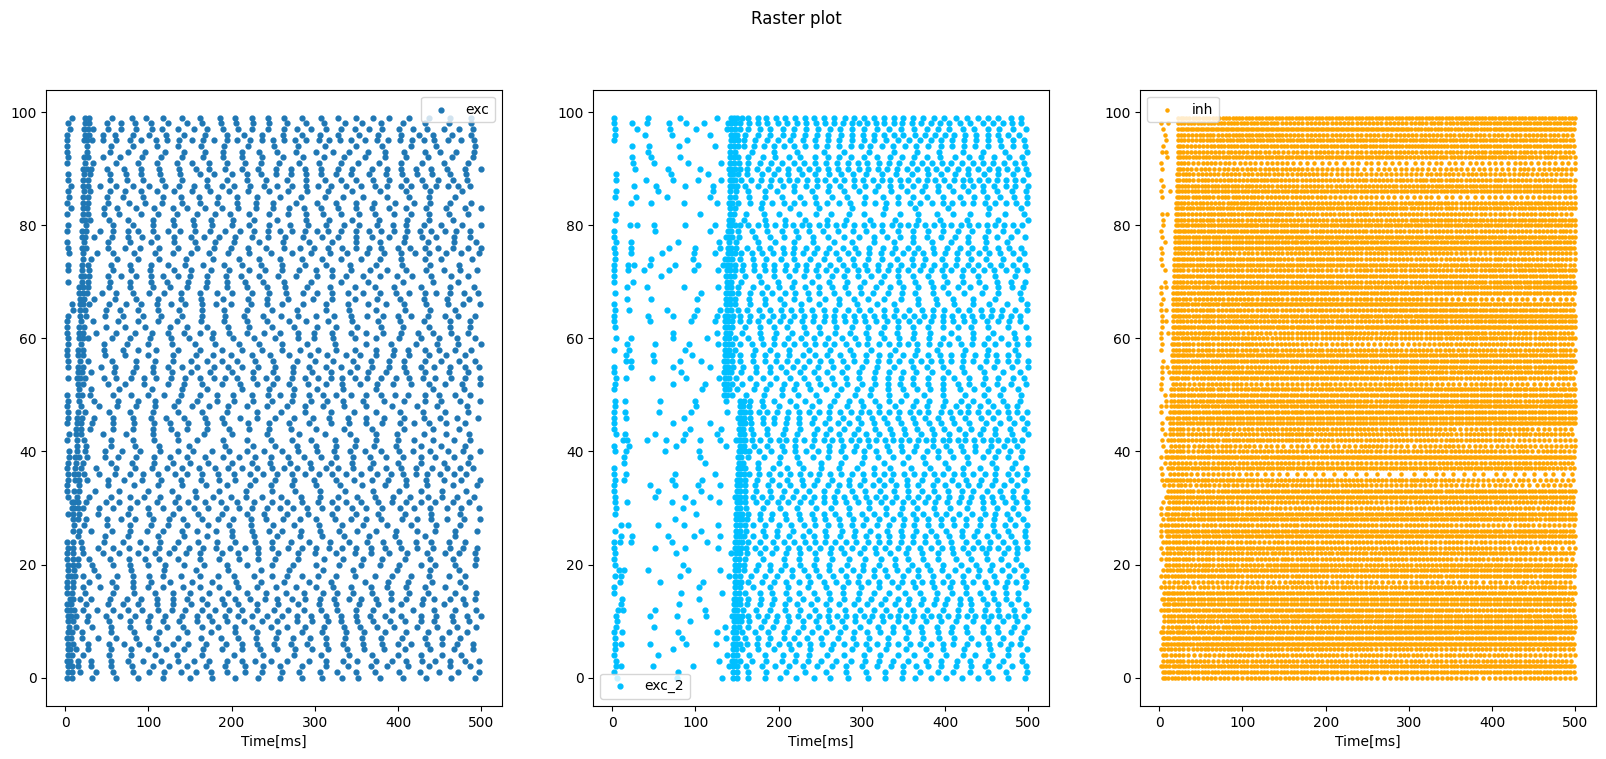

In [16]:
fig , ax = plt.subplots(1,3 , figsize=(20, 8))
ax[0].scatter(net["exc_spike",0]["spike",0][:,0],net["exc_spike",0]["spike",0][:,1], s = 12 , label = 'exc')
ax[0].set_xlabel('Time[ms]')
ax[0].xaxis.set_ticks(np.arange(0 , 501 , 100))
ax[0].legend()


ax[1].scatter(net["exc_spike",1]["spike",0][:,0],net["exc_spike",1]["spike",0][:,1],color = 'deepskyblue' , s = 12 , label = 'exc_2')
ax[1].set_xlabel('Time[ms]')
ax[1].xaxis.set_ticks(np.arange(0 , 501 , 100))
ax[1].legend()


ax[2].scatter(net["inh_spike",0]["spike",0][:,0],net["inh_spike",0]["spike",0][:,1], s = 5 ,color = 'orange', label = 'inh')
ax[2].set_xlabel('Time[ms]')
ax[2].legend()
fig.suptitle('Raster plot');